##Import Libraries, Start Query Engine

In [1]:
import json
import ast
import pandas as pd
import csv
import requests
import time
import traceback
from sqlalchemy import *
from sqlalchemy.orm import sessionmaker
from sqlalchemy.ext.declarative import declarative_base
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import datetime
import instaconfig
from pytz import timezone

from sklearn.neighbors.kde import KernelDensity
from sklearn.grid_search import GridSearchCV

instagram, database, search_tags = instaconfig.config()

engine = create_engine('mysql://%(user)s:%(pass)s@%(host)s' % database)
engine.execute('use instagram_master')

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 30 days
Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 30 days


In [2]:
q = '''
    SELECT *
    FROM posts
    WHERE searched_tag IN 
    %s ;
    ''' % ("('" + "','".join(search_tags[:7]) + "')")  # :7

print q

df = pd.read_sql_query(q,con = engine)


    SELECT *
    FROM posts
    WHERE searched_tag IN 
    ('busk','busker','buskers','busking','streetmusic','streetmusician','streetmusicians') ;
    


In [3]:
print len(df)
df.head(1)

8819


,searched_tag,created_time,post_id,image_url,lat,likes,longitude,post_url,text,user_id,...,date_month,date_week,date_day,day_of_week,media_type,low_res_url,thumbnail_url,stand_res_url,live_music,genre
0,busk,1438400810,1041703958383645915_647156236,None,14.550606,184,121.051199,https://instagram.com/p/504Dsgk1Tb/,"Reposted from @hope_aaa ""His voice is just too...",1041703995016696991,...,7,None,31,4,video,https://scontent.cdninstagram.com/hphotos-xaf1...,https://scontent.cdninstagram.com/hphotos-xaf1...,https://scontent.cdninstagram.com/hphotos-xaf1...,None,None


## Train Kernel Density Estimator

In [6]:
Xtrain = np.vstack((df.longitude, df.lat)).T
Xtrain *= np.pi/180

kde = KernelDensity(
        bandwidth=1e-4, 
        kernel='epanechnikov',
        metric='haversine',
        #algorithm='ball_tree',
      )

kde.fit(Xtrain)

KernelDensity(algorithm='auto', atol=0, bandwidth=0.0001, breadth_first=True,
       kernel='epanechnikov', leaf_size=40, metric='haversine',
       metric_params=None, rtol=0)

## Plot KDE and data points

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


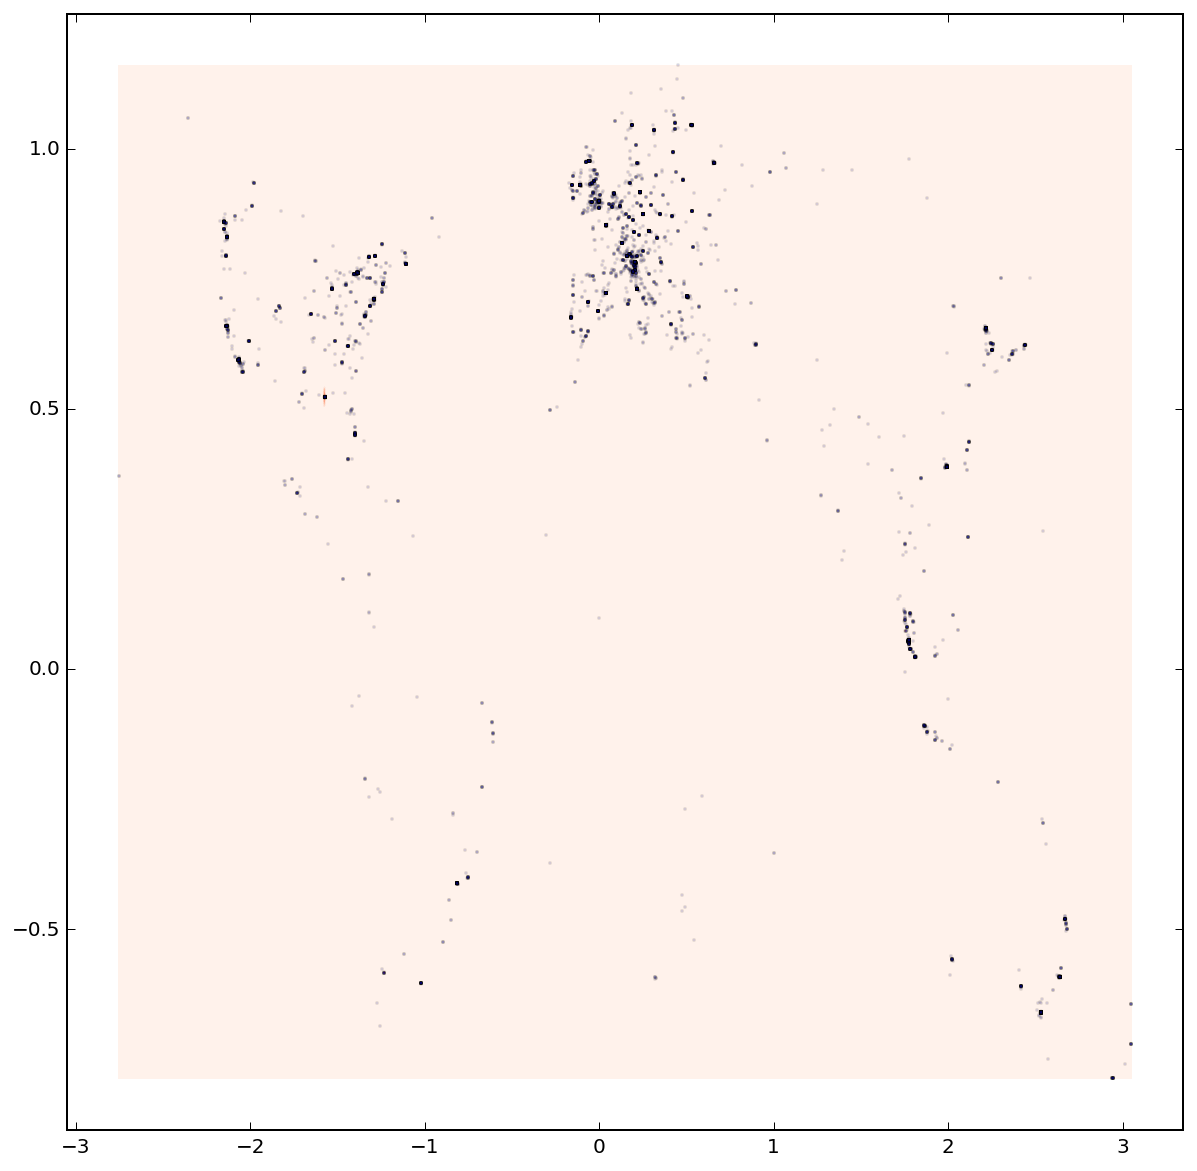

In [61]:
n = 1000
X = np.linspace(Xtrain[:,0].min(), Xtrain[:,0].max(), n)
Y = np.linspace(Xtrain[:,1].min(), Xtrain[:,1].max(), n)
X, Y = np.meshgrid(X, Y)
xy = np.vstack((X.flat, Y.flat)).T
logZ = kde.score_samples(xy).reshape(n,n)
Z = np.exp(logZ)

%config InlineBackend.figure_format='retina'
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 10)

levels = np.linspace(0, Z.max(), 25)
plt.contourf(X, Y, Z, levels=levels, cmap=plt.cm.Reds)
plt.scatter(Xtrain[:,0], Xtrain[:,1], s=1, alpha=0.1)

In [56]:
sf_coord = {
    'ul_lat' : 37.85,
    'ul_long' : -122.35,
    'lr_lat' : 37.7,
    'lr_long' : -122.6
    }

    #if 37.7 <= post['location']['latitude'] <= 37.85 \
    #                    and -122.6 <= post['location']['longitude'] <= -122.35:

In [78]:
def make_small_map(filter_coord, df):
    sf_df = df[(df.lat <= filter_coord['ul_lat']) & (df.longitude <= filter_coord['ul_long']) & (df.lat >= filter_coord['lr_lat']) & (df.longitude >= filter_coord['lr_long'])]

    Xtrain = np.vstack((sf_df.longitude, sf_df.lat)).T
    Xtrain *= np.pi/180

    kde = KernelDensity(
            bandwidth=1e-4, 
            kernel='epanechnikov',
            metric='haversine',
            #algorithm='ball_tree',
          )

    kde.fit(Xtrain)

    n = 1000
    X = np.linspace(Xtrain[:,0].min(), Xtrain[:,0].max(), n)
    Y = np.linspace(Xtrain[:,1].min(), Xtrain[:,1].max(), n)
    X, Y = np.meshgrid(X, Y)
    xy = np.vstack((X.flat, Y.flat)).T
    logZ = kde.score_samples(xy).reshape(n,n)
    Z = np.exp(logZ)

    pylab.rcParams['figure.figsize'] = (10, 10)

    levels = np.linspace(0, Z.max(), 25)
    plt.contourf(X, Y, Z, levels=levels, cmap=plt.cm.Reds)
    plt.scatter(Xtrain[:,0], Xtrain[:,1], s=1, alpha=0.1)

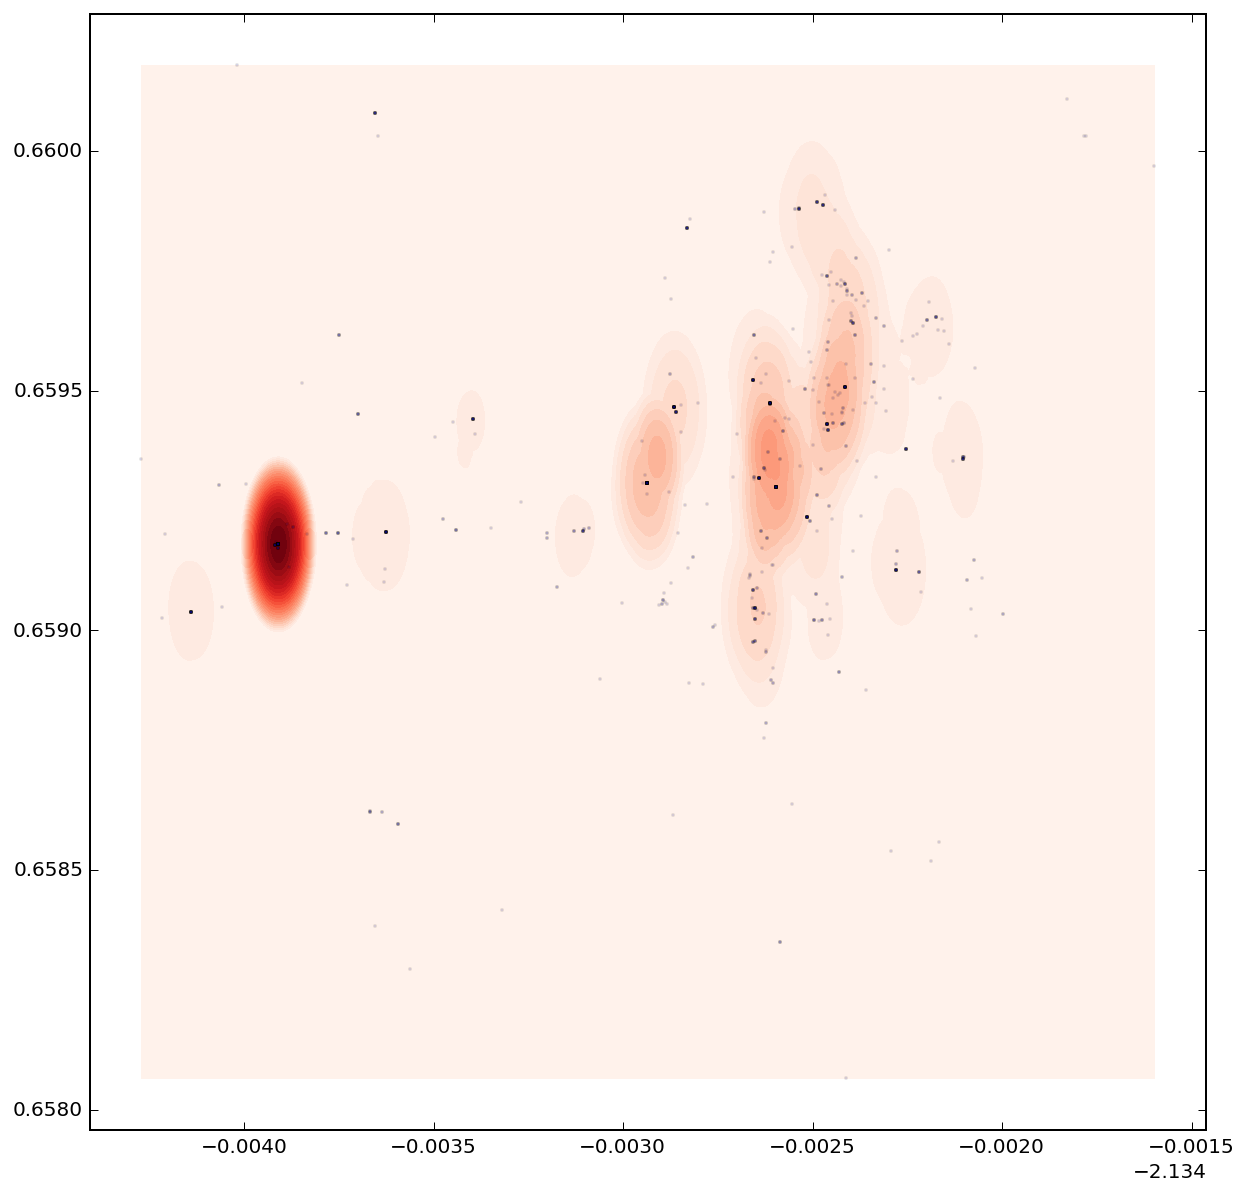

In [183]:
make_small_map(sf_coord, df)

## Temporal Calculations

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


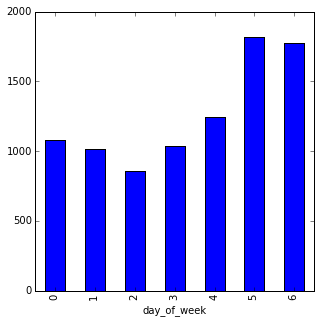

In [3]:
# Pictures binned by day of the week
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (5, 5)

days_of_week = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']


df.groupby(['day_of_week']).count()['searched_tag'].plot(kind = 'bar')

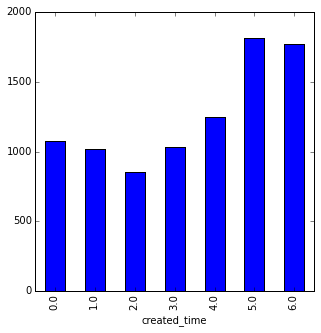

In [45]:
# Pictures binned by day of the week
df1['created_time'] = df['created_time'].apply(lambda x: datetime.datetime.fromtimestamp(x).weekday())
df1.groupby(['created_time']).count().plot(kind = 'bar')

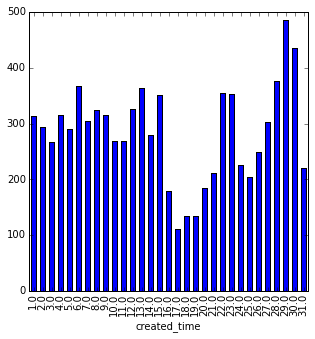

In [48]:
# Pictures binned by day of month
df1['created_time'] = df['created_time'].apply(lambda x: datetime.datetime.fromtimestamp(x).day)
df1.groupby(['created_time']).count().plot(kind = 'bar')

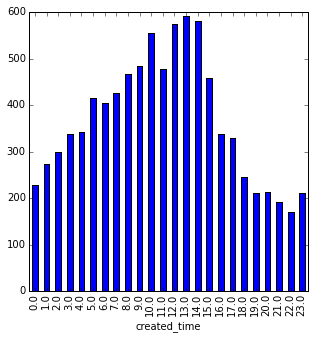

In [51]:
# Pictures binned by hour of day
# Pictures binned by day of the week
df1['created_time'] = df['created_time'].apply(lambda x: datetime.datetime.fromtimestamp(x).hour)
df1.groupby(['created_time']).count().plot(kind = 'bar')

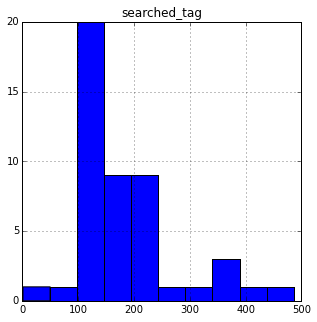

In [84]:
df1 = df.groupby(['date_year','date_month','date_day']).count().hist(column = 'searched_tag', bins = 10)

In [13]:
date_time = datetime.datetime.fromtimestamp(1438400810)
print date_time

2015-07-31 20:46:50


In [ ]:
from mpl_toolkits.basemap import Basemap

Xdeg, Ydeg = X*180/np.pi, Y*180/np.pi

m = Basemap(projection='cyl', 
            llcrnrlat=Ydeg.min(),
            urcrnrlat=Ydeg.max(), 
            llcrnrlon=Xdeg.min(),
            urcrnrlon=Xdeg.max(), 
            resolution='h')

m.drawmapboundary(fill_color='aqua')
m.drawcoastlines()
#Zmask = maskoceans(Xdeg, Ydeg, Z, resolution='h', grid=1.25)
Zmask = Z

plt.contourf(Xdeg, Ydeg, Zmask, levels=levels, cmap=plt.cm.Reds);

## dbscan

In [146]:
import folium
from sklearn.cluster import DBSCAN
from IPython.display import IFrame
from geopy.distance import EARTH_RADIUS

def make_small_map_dbscan(filter_coord, df):
    filtered_df = df[(df.lat <= filter_coord['ul_lat']) & (df.longitude <= filter_coord['ul_long']) & (df.lat >= filter_coord['lr_lat']) & (df.longitude >= filter_coord['lr_long'])]

    filtered_df
    Xtrain = np.vstack((filtered_df.longitude, filtered_df.lat)).T
    Xtrain *= np.pi/180

    print Xtrain
    n = 1000
    radians_per_meter = 1e-3 * EARTH_RADIUS

    db = DBSCAN(
            eps=50*radians_per_meter,
            min_samples=10,
            metric='haversine',
         )

    db.fit(Xtrain)
    
    n = 100
    X = np.linspace(Xtrain[:,0].min(), Xtrain[:,0].max(), n)
    Y = np.linspace(Xtrain[:,1].min(), Xtrain[:,1].max(), n)
    X, Y = np.meshgrid(X, Y)

    plt.contourf(X, Y, Z, levels=levels, cmap=plt.cm.Reds)
    plt.scatter(
        Xtrain[:,0], 
        Xtrain[:,1], 
        c=db.labels_, 
        s=20,
        lw=0,
        cmap=plt.cm.Greys)
    

[[-2.13713047  0.65920767]
 [-2.1364731   0.65988769]
 [-2.13734755  0.65921316]
 [-2.13710326  0.65921131]
 [-2.13664751  0.65908885]
 [-2.13762594  0.65920601]
 [-2.13641483  0.65950807]
 [-2.13713047  0.65920767]
 [-2.13641483  0.65950807]
 [-2.13653701  0.6598806 ]
 [-2.13688917  0.65973478]
 [-2.13654707  0.65987968]
 [-2.13659716  0.65929812]
 [-2.13659716  0.65929812]
 [-2.13623452  0.65961325]
 [-2.13638546  0.65968847]
 [-2.13613936  0.65959682]
 [-2.13653677  0.65987896]
 [-2.13642524  0.65971787]
 [-2.13659716  0.65929812]
 [-2.13682565  0.65888989]
 [-2.13633214  0.65931896]
 [-2.13641483  0.65950807]
 [-2.13641875  0.65946343]
 [-2.13640887  0.65969922]
 [-2.13654707  0.65987968]
 [-2.13648809  0.65920827]
 [-2.13664751  0.65908885]
 [-2.13762594  0.65920601]
 [-2.1364731   0.65988769]
 [-2.13659716  0.65929812]
 [-2.13641483  0.65950807]
 [-2.13660953  0.65889655]
 [-2.13631233  0.65950441]
 [-2.13659716  0.65929812]
 [-2.13641483  0.65950807]
 [-2.13641483  0.65950807]
 

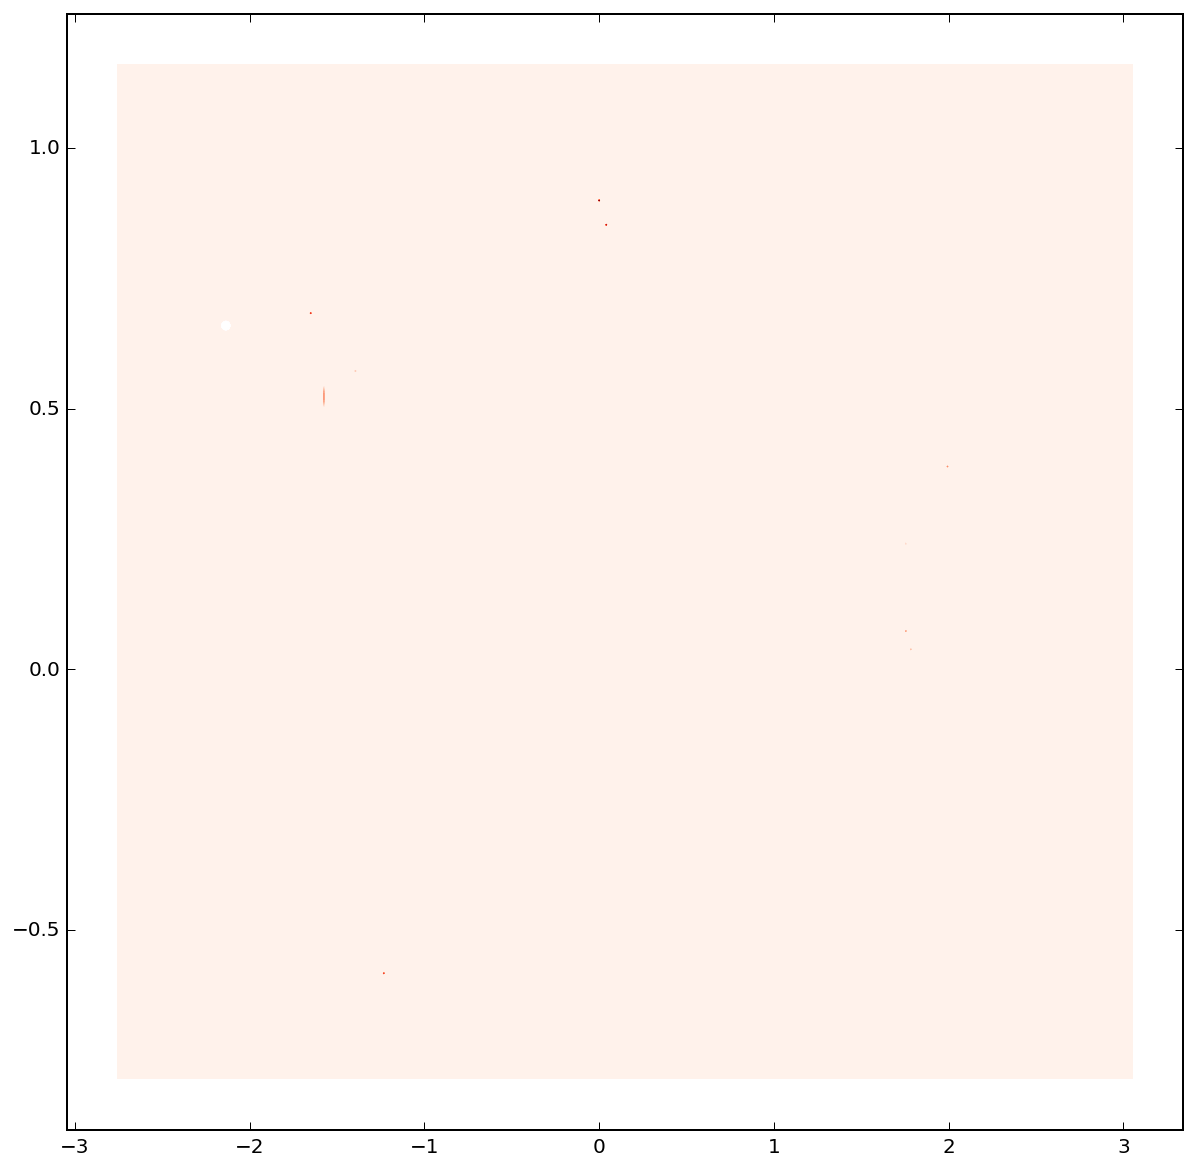

In [147]:
make_small_map_dbscan(sf_coord, df)

In [14]:
def make_circle(lat,lon,map_osm): 
    map_osm.circle_marker(location = [lat,lon],radius=40,line_color='#3186cc',fill_color='#3186cc')

In [ ]:
df.apply(lambda x,y: x+y)

In [43]:
import folium
from IPython.display import IFrame

from geopy.geocoders import Nominatim

search_location = 'London'

geolocator = Nominatim()

geolocation = geolocator.geocode(search_location)

map_osm = folium.Map(location=[geolocation.latitude, geolocation.longitude],
                    tiles='OpenStreetMap')

pics = df[['lat','longitude','stand_res_url']].values

colors = [
    '#d73027',
    '#f46d43',
    '#fdae61',
    '#fee090',
    '#e0f3f8',
    '#abd9e9',
    '#74add1',
    '#4575b4'
]

color_labels = [colors[label % 7] for label in labels]

def make_circle(lat,lon,image_url,color_label): 
    map_osm.circle_marker(
        location = [lat,lon],
        radius=100,
        line_color=color_label,
        fill_color=color_label,
        popup = '<img src={url} width=200 height=200><br>'.format(
            url=image_url)
    )
    
make_circle_vec = np.vectorize(make_circle)

make_circle_vec(pics[:,0],pics[:,1],pics[:,2],color_labels)

map_osm.create_map(path='osm.html')

IFrame('osm.html', 700, 700)



In [31]:
lat_long_test[:,0]

array([ 37.76981719,  37.80877973,  37.77013198, ...,  37.80605045,
        37.80605045,  37.81700119])

In [52]:
sf_df['stand_res_url'].values[0]

'https://scontent.cdninstagram.com/hphotos-xaf1/t51.2885-15/s640x640/sh0.08/e35/11350924_1168169466532055_1111188917_n.jpg'

In [38]:
from sklearn.cluster import DBSCAN
from sklearn import metrics

##############################################################################
# Compute DBSCAN
db = DBSCAN(eps=1e-5, min_samples=3).fit(Xtrain)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)
#print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
#print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
#print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
#print("Adjusted Rand Index: %0.3f"
#      % metrics.adjusted_rand_score(labels_true, labels))
#print("Adjusted Mutual Information: %0.3f"
#      % metrics.adjusted_mutual_info_score(labels_true, labels))
#print("Silhouette Coefficient: %0.3f"
#      % metrics.silhouette_score(X, labels))

Estimated number of clusters: 576


In [12]:
labels = [int(label) for label in labels]

print labels

[44, 0, 2, 0, 0, 0, 2, 7, -1, 0, 5, 5, 0, 0, 2, 0, 7, 12, 0, 0, 0, 0, 0, 2, 7, 0, 12, 12, 0, 0, 16, 0, 0, 0, 0, 0, 0, 2, 4, 30, 2, 0, 7, 5, 4, 0, 0, 0, 0, 4, 0, 0, 12, 5, 4, 2, 4, 4, 0, 59, 0, 5, 59, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 5, 0, 4, 0, 0, 5, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 16, 16, 0, 0, 4, 0, 2, 0, 0, 0, 0, 5, 7, 0, 9, 24, 0, 9, 24, 24, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 4, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 11, 0, 0, 0, 2, 24, 4, 2, 4, 0, 0, 7, 55, 20, 0, 0, 0, 0, 16, 2, 32, 4, 4, 24, 4, 4, 6, 9, 0, 0, 13, 0, 13, 2, 55, 2, 0, 0, 2, 12, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 11, 6, 0, 4, 0, 0, 13, 0, 0, 0, 16, 0, 2, 12, 4, 11, 4, 11, 7, 0, 13, 0, 4, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 16, 0, 2, 2, 5, 0, 2, 2, 0, 7, 4, 11, 12, 32, 0, 9, 0, 2, 39, 16, 28, 0, 0, 0, 4, 45, 16, 0, 0, 0, 0, 0, 0, 2, 4, 4, 9, 2, 2, 2, 2, 0, 0, 4, 0, 0, 0, 12, 0, 0, 7, 16, 2, 16, 12, 12, 0, 4, 12, 7, 9, 2, 12, 33, 2, 0, 2, 0, 2, 0, 2, 2, 0, 0, 4, 0, 2, 2, 4, 2, 11, 4, 0, 0, 0, 5, 7, 62, 7, 5,

In [25]:
colors = [
    '#d73027',
    '#f46d43',
    '#fdae61',
    '#fee090',
    '#e0f3f8',
    '#abd9e9',
    '#74add1',
    '#4575b4'
]

color_labels = [colors[label % 7] for label in labels]
print color_labels

#color = colors[labels % 3]

['#fdae61', '#d73027', '#fdae61', '#d73027', '#d73027', '#d73027', '#fdae61', '#d73027', '#74add1', '#d73027', '#abd9e9', '#abd9e9', '#d73027', '#d73027', '#fdae61', '#d73027', '#d73027', '#abd9e9', '#d73027', '#d73027', '#d73027', '#d73027', '#d73027', '#fdae61', '#d73027', '#d73027', '#abd9e9', '#abd9e9', '#d73027', '#d73027', '#fdae61', '#d73027', '#d73027', '#d73027', '#d73027', '#d73027', '#d73027', '#fdae61', '#e0f3f8', '#fdae61', '#fdae61', '#d73027', '#d73027', '#abd9e9', '#e0f3f8', '#d73027', '#d73027', '#d73027', '#d73027', '#e0f3f8', '#d73027', '#d73027', '#abd9e9', '#abd9e9', '#e0f3f8', '#fdae61', '#e0f3f8', '#e0f3f8', '#d73027', '#fee090', '#d73027', '#abd9e9', '#fee090', '#d73027', '#d73027', '#d73027', '#d73027', '#d73027', '#d73027', '#d73027', '#d73027', '#abd9e9', '#d73027', '#d73027', '#d73027', '#d73027', '#abd9e9', '#d73027', '#e0f3f8', '#d73027', '#d73027', '#abd9e9', '#d73027', '#d73027', '#d73027', '#e0f3f8', '#d73027', '#d73027', '#d73027', '#d73027', '#d73027'

In [23]:
len(colors)

0

In [20]:
colors[labels[0] % 3]

IndexError: list index out of range

In [104]:
import matplotlib.colors as colors
import matplotlib.cm as cmx

values = range(10)

jet = cm = plt.get_cmap('jet') 
cNorm  = colors.Normalize(vmin=0, vmax=values[-1])
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)

colorVal = scalarMap.to_rgba(range(36))

(0, 9)


In [101]:
colorVal

array([[ 0.        ,  0.        ,  0.5       ,  1.        ],
       [ 0.        ,  0.        ,  0.99910873,  1.        ],
       [ 0.        ,  0.37843137,  1.        ,  1.        ],
       [ 0.        ,  0.83333333,  1.        ,  1.        ],
       [ 0.30044276,  1.        ,  0.66729918,  1.        ],
       [ 0.66729918,  1.        ,  0.30044276,  1.        ],
       [ 1.        ,  0.90123457,  0.        ,  1.        ],
       [ 1.        ,  0.48002905,  0.        ,  1.        ],
       [ 0.99910873,  0.07334786,  0.        ,  1.        ],
       [ 0.5       ,  0.        ,  0.        ,  1.        ]])

In [105]:
''==''

True

In [110]:
map_osm.location = [0,0]

print map_osm.location

[0, 0]
